In [1]:
# --- STEP 0: Master Library Installation ---
print("Installing Environment...")

# 1. Çakışmaları önlemek için Temel Kütüphaneleri sabitliyoruz (NumPy < 2)
!pip install "numpy<2" "scipy<1.13" "pandas<2.2" "matplotlib<3.8" > /dev/null

# 2. PyTorch Stack (CUDA Sürümü) - TorchText 0.17.0 ile uyumlu olan 2.2.0 sürümü
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu121 > /dev/null

# 3. Geriye kalan tüm NLP Araçları (Q1, Q2, Q3, Q4, Q5 için hepsi dahil)
!pip install torchtext==0.17.0 transformers==4.38.2 datasets scikit-learn \
             portalocker spacy captum rank_bm25 sentence-transformers \
             torchmetrics bert_score accelerate > /dev/null

# 4. Dil Modellerini İndir (Spacy)
!python -m spacy download en_core_web_sm > /dev/null
!python -m spacy download de_core_news_sm > /dev/null

print("Environment Ready..")

Installing Environment...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires tornado==6.4.2, but you have tornado 6.5.2 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
dopamine-rl 4.1.2 requires g

In [2]:
# --- STEP 1: Imports & Load Data (Hugging Face Version) ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.vocab as vocab
from transformers import BertTokenizer, logging
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import time

# Gereksiz uyarıları kapat
logging.set_verbosity_error()

# Cihaz kontrolü
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Libraries Imported. Using device: {device}")

# 1. Veri Setini Yükle (Hugging Face - En güvenli yöntem)
print("\nLoading IMDb dataset via Hugging Face...")
dataset = load_dataset("imdb")
print("Dataset Loaded Successfully.")

# 2. Listeye Çevir (Tekrar tekrar kullanabilmek için)
train_data_list = list(dataset['train'])
test_data_list = list(dataset['test'])

print(f"Train Size: {len(train_data_list)}")
print(f"Test Size:  {len(test_data_list)}")

# 3. Dağılımı Kontrol Et (12.500 Negatif / 12.500 Pozitif olmalı)
train_labels = [item['label'] for item in train_data_list]
print(f"Train Distribution: {Counter(train_labels)}") 

# Güvenlik Kilidi: Eğer veri eksikse hata verip dursun
if len(train_data_list) != 25000:
    raise ValueError("FATAL ERROR: Dataset incomplete. Only loaded partial data!")

Libraries Imported. Using device: cuda

Loading IMDb dataset via Hugging Face...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset Loaded Successfully.
Train Size: 25000
Test Size:  25000
Train Distribution: Counter({0: 12500, 1: 12500})


In [3]:
# ---  STEP 2: Adapting the Pipeline ---

# Define Tokenizers
tokenizer_glove = get_tokenizer('basic_english')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

# Build Vocabulary
print("Building GloVe Vocabulary...")
vocab_glove = build_vocab_from_iterator(
    map(tokenizer_glove, (item['text'] for item in train_data_list)), # Changed to item['text']
    specials=["<unk>", "<pad>"],
    min_freq=5
)
vocab_glove.set_default_index(vocab_glove["<unk>"])

# Load GloVe Vectors
print("Loading GloVe Vectors...")
glove = vocab.GloVe(name='6B', dim=300)

# Create Embedding Matrix
embedding_matrix_glove = torch.zeros((len(vocab_glove), 300))
for i, token in enumerate(vocab_glove.get_itos()):
    embedding_matrix_glove[i] = glove.get_vecs_by_tokens(token)

# --- The New Collate Function ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_batch(batch):
    labels = []
    texts_glove = []
    
    for item in batch:
        labels.append(item['label']) 
        # Process for GloVe
        tokens = tokenizer_glove(item['text'])
        numerical_tokens = [vocab_glove[token] for token in tokens]
        texts_glove.append(torch.tensor(numerical_tokens, dtype=torch.long))

    texts_glove_padded = pad_sequence(texts_glove, batch_first=True, padding_value=vocab_glove["<pad>"])
    labels = torch.tensor(labels, dtype=torch.float)
    
    return texts_glove_padded.to(device), labels.to(device)

# Create DataLoaders
BATCH_SIZE = 64
train_dataloader = DataLoader(train_data_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data_list, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(" DataLoaders are ready")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Building GloVe Vocabulary...
Loading GloVe Vectors...


.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                               
100%|█████████▉| 399999/400000 [00:42<00:00, 9519.12it/s]


 DataLoaders are ready


In [4]:
# --- STEP 3 ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# We keep these for tokenization/vocab, but NOT for loading the dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.vocab as vocab
from transformers import BertTokenizer, logging

# Standard Data Science imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import time

# Set transformers logging to error only
logging.set_verbosity_error()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("---")
print("Clean imports successful.")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
print("---")

---
Clean imports successful.
PyTorch version: 2.2.0+cu121
Using device: cuda
---


In [5]:
# --- STEP 4 LOAD DATA  ---
from datasets import load_dataset
from collections import Counter

#  Load the dataset
print("Loading IMDb dataset via Hugging Face...")
dataset = load_dataset("imdb")
print(" Dataset Loaded Successfully.")

# Convert to standard lists for our pipeline
train_data_list = list(dataset['train'])
test_data_list = list(dataset['test'])

print(f"Train Size: {len(train_data_list)}")
print(f"Test Size:  {len(test_data_list)}")

# Verify counts immediately
train_labels = [item['label'] for item in train_data_list]
print(f"Train Distribution: {Counter(train_labels)}") 

if len(train_data_list) != 25000:
    raise ValueError("FATAL ERROR: Dataset incomplete.")

Loading IMDb dataset via Hugging Face...
 Dataset Loaded Successfully.
Train Size: 25000
Test Size:  25000
Train Distribution: Counter({0: 12500, 1: 12500})


In [6]:
# --- Step 5: Tokenizers, Vocabulary, and GloVe Embeddings (Hugging Face Version) ---

print("1. Setting up Tokenizers...")

tokenizer_glove = get_tokenizer('basic_english')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

print("2. Preparing data lists...")
if 'dataset' not in globals():
    from datasets import load_dataset
    print("   (Reloading dataset variable just in case...)")
    dataset = load_dataset("imdb")

train_data_list = list(dataset['train'])
test_data_list = list(dataset['test'])
print(f"   Data ready. Train size: {len(train_data_list)}")

print("3. Building GloVe Vocabulary...")

vocab_glove = build_vocab_from_iterator(
    map(tokenizer_glove, (item['text'] for item in train_data_list)),
    specials=["<unk>", "<pad>"],
    min_freq=5
)
vocab_glove.set_default_index(vocab_glove["<unk>"])
print(f"   Vocabulary built. Total size: {len(vocab_glove)} words.")

print("4. Loading GloVe Vectors (6B, 300d)...")
glove = vocab.GloVe(name='6B', dim=300)
print("   GloVe vectors loaded.")

print("5. Creating Embedding Matrix...")
embedding_matrix_glove = torch.zeros((len(vocab_glove), 300))
for i, token in enumerate(vocab_glove.get_itos()):
    embedding_matrix_glove[i] = glove.get_vecs_by_tokens(token)

print(f"   Embedding matrix created with shape: {embedding_matrix_glove.shape}")
print("---  Setup for GloVe models is ready ---")

1. Setting up Tokenizers...
2. Preparing data lists...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


   Data ready. Train size: 25000
3. Building GloVe Vocabulary...
   Vocabulary built. Total size: 30123 words.
4. Loading GloVe Vectors (6B, 300d)...
   GloVe vectors loaded.
5. Creating Embedding Matrix...
   Embedding matrix created with shape: torch.Size([30123, 300])
---  Setup for GloVe models is ready ---


In [7]:
# --- Step 6: Create DataLoader and Collate Function  ---
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Ensure the device is set to GPU (T4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the Collate Function
def collate_batch(batch):
    labels = []
    texts_glove = []
    texts_bert = []

    for item in batch:
        labels.append(item['label']) 
        #Process for GloVe
        tokens_glove = tokenizer_glove(item['text'])
        # Look up indices in vocab; handle unknown words
        numerical_tokens = [vocab_glove[token] for token in tokens_glove]
        texts_glove.append(torch.tensor(numerical_tokens, dtype=torch.long))
        
        # Process for BERT 
        texts_bert.append(item['text'])

    # Convert labels to a tensor
    labels = torch.tensor(labels, dtype=torch.float) # Float is needed for BCE loss

    # --- Pad the sequences ---
    
    # Pad GloVe sequences
    texts_glove_padded = pad_sequence(texts_glove, batch_first=True, padding_value=vocab_glove["<pad>"])

    # Pad BERT sequences
    bert_inputs = tokenizer_bert(
        texts_bert, 
        padding=True, 
        truncation=True, 
        max_length=512, # Max length for BERT
        return_tensors="pt" # Return PyTorch tensors
    )
    
    # Send all tensors to the GPU
    return {
        'labels': labels.to(device),
        'glove_ids': texts_glove_padded.to(device),
        'bert_input_ids': bert_inputs['input_ids'].to(device),
        'bert_attention_mask': bert_inputs['attention_mask'].to(device)
    }

# Create the DataLoaders
BATCH_SIZE = 64

print(f"Creating DataLoaders with Batch Size: {BATCH_SIZE}")
train_dataloader = DataLoader(train_data_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data_list, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("DataLoaders created.")

# Check one batch
print("\n--- Checking one batch from the train_dataloader ---")
try:
    one_batch = next(iter(train_dataloader))
    print(f"Keys in batch: {one_batch.keys()}")
    print(f"Labels shape: {one_batch['labels'].shape}")
    print(f"GloVe IDs shape: {one_batch['glove_ids'].shape}")
    print(f"BERT IDs shape: {one_batch['bert_input_ids'].shape}")
    
    # Verify label values (should be 0s and 1s)
    print(f"Unique labels in batch: {torch.unique(one_batch['labels'])}")
except Exception as e:
    print(f"Error checking batch: {e}")

print("--- Data pipeline is complete ---")

Using device: cuda
Creating DataLoaders with Batch Size: 64
DataLoaders created.

--- Checking one batch from the train_dataloader ---
Keys in batch: dict_keys(['labels', 'glove_ids', 'bert_input_ids', 'bert_attention_mask'])
Labels shape: torch.Size([64])
GloVe IDs shape: torch.Size([64, 783])
BERT IDs shape: torch.Size([64, 512])
Unique labels in batch: tensor([0., 1.], device='cuda:0')
--- Data pipeline is complete ---


In [8]:
# --- STEP 7: Define the RecurrentClassifier Class ---

class RecurrentClassifier(nn.Module):
    def __init__(self, model_type, embedding_matrix, hidden_dim, num_layers, dropout):
        super(RecurrentClassifier, self).__init__()
        
        vocab_size, embedding_dim = embedding_matrix.shape
        
        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, 
            freeze=True, # Keep GloVe vectors fixed
            padding_idx=vocab_glove["<pad>"]
        )
        
        # Recurrent Layer (LSTM or GRU)
        if model_type.upper() == "LSTM":
            self.rnn = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=True, # This makes it a Bi-LSTM
                batch_first=True,   # Our data is (batch_size, seq_len, features)
                dropout=dropout if num_layers > 1 else 0
            )
        elif model_type.upper() == "GRU":
            self.rnn = nn.GRU(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=True, # This makes it a Bi-GRU
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0
            )
        else:
            raise ValueError("model_type must be 'LSTM' or 'GRU'")
            
        # Dropout Layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully Connected (Linear) Layer
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, glove_ids):
        # Pass through embedding layer
        embedded = self.embedding(glove_ids)
        
        # Pass through RNN layer
        rnn_output, hidden = self.rnn(embedded)
        

        if isinstance(hidden, tuple):
            hidden = hidden[0] # Get only the 'h' state from (h, c) for LSTM
            
        # Concatenate final forward and backward hidden states
        final_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        # Apply dropout and FC layer
        final_hidden_dropout = self.dropout(final_hidden)
        output = self.fc(final_hidden_dropout)
        
        return output

print("✅ Model Class Defined.")

✅ Model Class Defined.


In [9]:
# --- STEP 8: Instantiate "Lite" Models, Optimizer, and Loss Function ---

# HYPERPARAMETERS 
VOCAB_SIZE = len(vocab_glove)
EMBEDDING_DIM = 300  
HIDDEN_DIM = 128    
NUM_LAYERS = 1      
DROPOUT = 0.5        
LEARNING_RATE = 1e-3

# Instantiate the Bi-LSTM Model
print("Initializing Bi-LSTM...")
model_lstm = RecurrentClassifier(
    model_type='LSTM',
    embedding_matrix=embedding_matrix_glove,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

# Instantiate the Bi-GRU Model
print("Initializing Bi-GRU...")
model_gru = RecurrentClassifier(
    model_type='GRU',
    embedding_matrix=embedding_matrix_glove,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

# Move models to the GPU
model_lstm.to(device)
model_gru.to(device)

# Define the Loss Function
criterion = nn.BCEWithLogitsLoss()

# Define the Optimizers
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)


print(f"Bi-LSTM Parameters: {sum(p.numel() for p in model_lstm.parameters() if p.requires_grad):,}")
print(f"Bi-GRU Parameters:  {sum(p.numel() for p in model_gru.parameters() if p.requires_grad):,}")
print("--- 'Lite' Models (LSTM & GRU) and Optimizers are ready ---")

Initializing Bi-LSTM...
Initializing Bi-GRU...
Bi-LSTM Parameters: 440,577
Bi-GRU Parameters:  330,497
--- 'Lite' Models (LSTM & GRU) and Optimizers are ready ---


In [10]:
# --- STEP 9: Define Training and Evaluation Functions ---
import time
from sklearn.metrics import f1_score

# Helper: Calculate Binary Accuracy
def binary_accuracy(preds, y):
    # Round predictions to the closest integer (0 or 1)
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

# --- Training Function (One Epoch) ---
def train_model(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() 
    
    for batch in dataloader:
        optimizer.zero_grad()
        
        # Get data from batch 
        glove_ids = batch['glove_ids']
        labels = batch['labels']
        
        # Forward pass
        predictions = model(glove_ids).squeeze(1)
        
        # Loss & Acc
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

# --- Evaluation Function ---
def evaluate_model(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []
    
    model.eval() # Disable Dropout
    
    with torch.no_grad():
        for batch in dataloader:
            glove_ids = batch['glove_ids']
            labels = batch['labels']
            
            predictions = model(glove_ids).squeeze(1)
            
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            # Store for F1 score
            rounded_preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(rounded_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate Macro-F1
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return (epoch_loss / len(dataloader), epoch_acc / len(dataloader), macro_f1)

# --- Timer ---
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

print("✅ Training and Evaluation functions defined.")

✅ Training and Evaluation functions defined.


In [11]:
# --- STEP 10.1: Train the Bi-LSTM Model ---

NUM_EPOCHS = 5
print(f"--- Starting Glove + Bi-LSTM Model Training for {NUM_EPOCHS} Epochs ---")

# Storage for plotting later
history_lstm = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_model(model_lstm, train_dataloader, optimizer_lstm, criterion)
    
    # Evaluate
    val_loss, val_acc, val_f1 = evaluate_model(model_lstm, test_dataloader, criterion)
    
    end_time = time.time()
    
    # Store metrics
    history_lstm['train_loss'].append(train_loss)
    history_lstm['train_acc'].append(train_acc)
    history_lstm['val_loss'].append(val_loss)
    history_lstm['val_acc'].append(val_acc)
    history_lstm['val_f1'].append(val_f1)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_lstm.state_dict(), 'model_lstm_glove.pt')
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}% | Val. F1: {val_f1:.3f}')

print("--- Glove + Bi-LSTM Training Complete ---")

--- Starting Glove + Bi-LSTM Model Training for 5 Epochs ---
Epoch: 01 | Time: 3m 35s
	Train Loss: 0.680 | Train Acc: 57.57%
	 Val. Loss: 0.611 |  Val. Acc: 67.69% | Val. F1: 0.668
Epoch: 02 | Time: 3m 37s
	Train Loss: 0.590 | Train Acc: 70.46%
	 Val. Loss: 0.646 |  Val. Acc: 63.98% | Val. F1: 0.600
Epoch: 03 | Time: 3m 37s
	Train Loss: 0.596 | Train Acc: 68.66%
	 Val. Loss: 0.651 |  Val. Acc: 55.70% | Val. F1: 0.456
Epoch: 04 | Time: 3m 35s
	Train Loss: 0.426 | Train Acc: 81.47%
	 Val. Loss: 0.371 |  Val. Acc: 84.09% | Val. F1: 0.839
Epoch: 05 | Time: 3m 36s
	Train Loss: 0.325 | Train Acc: 86.92%
	 Val. Loss: 0.296 |  Val. Acc: 87.96% | Val. F1: 0.880
--- Glove + Bi-LSTM Training Complete ---


In [12]:
# --- STEP 10.2: Train the Bi-GRU Model ---

print(f"--- 🚀 Starting Glove + Bi-GRU Model Training for {NUM_EPOCHS} Epochs ---")

# Storage
history_gru = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_loss_gru = float('inf')

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_model(model_gru, train_dataloader, optimizer_gru, criterion)
    
    # Evaluate
    val_loss, val_acc, val_f1 = evaluate_model(model_gru, test_dataloader, criterion)
    
    end_time = time.time()
    
    # Store metrics
    history_gru['train_loss'].append(train_loss)
    history_gru['train_acc'].append(train_acc)
    history_gru['val_loss'].append(val_loss)
    history_gru['val_acc'].append(val_acc)
    history_gru['val_f1'].append(val_f1)
    
    # Save best model
    if val_loss < best_val_loss_gru:
        best_val_loss_gru = val_loss
        torch.save(model_gru.state_dict(), 'model_gru_glove.pt')
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}% | Val. F1: {val_f1:.3f}')

print("--- Glove + Bi-GRU Training Complete ---")

--- 🚀 Starting Glove + Bi-GRU Model Training for 5 Epochs ---
Epoch: 01 | Time: 3m 28s
	Train Loss: 0.607 | Train Acc: 66.16%
	 Val. Loss: 0.443 |  Val. Acc: 80.59% | Val. F1: 0.804
Epoch: 02 | Time: 3m 27s
	Train Loss: 0.365 | Train Acc: 84.89%
	 Val. Loss: 0.294 |  Val. Acc: 87.82% | Val. F1: 0.878
Epoch: 03 | Time: 3m 27s
	Train Loss: 0.294 | Train Acc: 88.23%
	 Val. Loss: 0.265 |  Val. Acc: 89.10% | Val. F1: 0.891
Epoch: 04 | Time: 3m 26s
	Train Loss: 0.254 | Train Acc: 90.06%
	 Val. Loss: 0.250 |  Val. Acc: 89.86% | Val. F1: 0.898
Epoch: 05 | Time: 3m 32s
	Train Loss: 0.223 | Train Acc: 91.37%
	 Val. Loss: 0.237 |  Val. Acc: 90.36% | Val. F1: 0.904
--- Glove + Bi-GRU Training Complete ---


In [13]:
# --- STEP 11: Define Contextual (BERT) Recurrent Model ---
from transformers import BertModel

class ContextualRecurrentClassifier(nn.Module):
    def __init__(self, model_type, hidden_dim, num_layers, dropout):
        super(ContextualRecurrentClassifier, self).__init__()
        
        # 1. BERT Layer (The "Contextual Embedding")
        # We load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # FREEZE BERT
        # Save memory and time.
        for param in self.bert.parameters():
            param.requires_grad = False
            
        bert_hidden_size = 768 
        
        # 2. Recurrent Layer (LSTM or GRU)
        if model_type.upper() == "LSTM":
            self.rnn = nn.LSTM(
                input_size=bert_hidden_size,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=True, 
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0
            )
        elif model_type.upper() == "GRU":
            self.rnn = nn.GRU(
                input_size=bert_hidden_size,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=True,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0
            )
        else:
            raise ValueError("model_type must be 'LSTM' or 'GRU'")
            
        # Dropout & FC Layers
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, input_ids, attention_mask):
        # Get BERT Embeddings
        # We use no_grad() to ensure gradients aren't calculated for BERT
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # We use 'last_hidden_state' which is the sequence of vectors (batch, seq_len, 768)
        embeddings = bert_output.last_hidden_state
        
        # 2. RNN
        rnn_output, hidden = self.rnn(embeddings)
        
        # 3. Extract Final State
        if isinstance(hidden, tuple):
            hidden = hidden[0] # LSTM tuple
            
        # Concatenate forward/backward
        final_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        
        return self.fc(self.dropout(final_hidden))

print("Contextual (BERT) Model Class Defined.")

Contextual (BERT) Model Class Defined.


In [14]:
# --- OPTIMIZATION: Speed up Training ---


def collate_batch(batch):
    labels = []
    texts_glove = []
    texts_bert = []

    for item in batch:
        labels.append(item['label']) 
        tokens_glove = tokenizer_glove(item['text'])
        numerical_tokens = [vocab_glove[token] for token in tokens_glove]
        texts_glove.append(torch.tensor(numerical_tokens, dtype=torch.long))
        
        # Process for BERT
        texts_bert.append(item['text'])

    # Pad GloVe
    texts_glove_padded = pad_sequence(texts_glove, batch_first=True, padding_value=vocab_glove["<pad>"])
    
    # Pad BERT 
    bert_inputs = tokenizer_bert(
        texts_bert, 
        padding=True, 
        truncation=True, 
        max_length=128,  
        return_tensors="pt"
    )
    
    labels = torch.tensor(labels, dtype=torch.float)
    
    return {
        'labels': labels.to(device),
        'glove_ids': texts_glove_padded.to(device),
        'bert_input_ids': bert_inputs['input_ids'].to(device),
        'bert_attention_mask': bert_inputs['attention_mask'].to(device)
    }


BATCH_SIZE = 64 

print(f"Re-creating DataLoaders with max_length=128...")
train_dataloader = DataLoader(train_data_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data_list, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print("Optimization Complete. Ready to Train.")

Re-creating DataLoaders with max_length=128...
Optimization Complete. Ready to Train.


In [15]:
# --- STEP 12: Train Bi-LSTM + BERT ---

# Define Hyperparameters (Same as before for fairness)
HIDDEN_DIM = 128
NUM_LAYERS = 1
DROPOUT = 0.5
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5

print("Initializing BERT + Bi-LSTM...")
model_bert_lstm = ContextualRecurrentClassifier(
    model_type='LSTM',
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

optimizer_bert = torch.optim.Adam(model_bert_lstm.parameters(), lr=LEARNING_RATE)

print(f"--- Starting BERT + Bi-LSTM Training for {NUM_EPOCHS} Epochs ---")

history_bert_lstm = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # --- TRAIN LOOP ---
    model_bert_lstm.train()
    train_loss = 0
    train_acc = 0
    
    for batch in train_dataloader:
        optimizer_bert.zero_grad()
        
        # Load BERT-specific inputs
        input_ids = batch['bert_input_ids']
        mask = batch['bert_attention_mask']
        labels = batch['labels']
        
        predictions = model_bert_lstm(input_ids, mask).squeeze(1)
        
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        
        loss.backward()
        optimizer_bert.step()
        
        train_loss += loss.item()
        train_acc += acc.item()
        
    # --- EVAL LOOP ---
    model_bert_lstm.eval()
    val_loss = 0
    val_acc = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['bert_input_ids']
            mask = batch['bert_attention_mask']
            labels = batch['labels']
            
            predictions = model_bert_lstm(input_ids, mask).squeeze(1)
            
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            
            val_loss += loss.item()
            val_acc += acc.item()
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(rounded_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Metrics
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_acc = train_acc / len(train_dataloader)
    avg_val_loss = val_loss / len(test_dataloader)
    avg_val_acc = val_acc / len(test_dataloader)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    history_bert_lstm['train_loss'].append(avg_train_loss)
    history_bert_lstm['val_acc'].append(avg_val_acc)
    
    # Save
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_bert_lstm.state_dict(), 'model_lstm_bert.pt')
    
    mins, secs = epoch_time(start_time, time.time())
    print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {avg_train_loss:.3f} | Train Acc: {avg_train_acc*100:.2f}%')
    print(f'\t Val. Loss: {avg_val_loss:.3f} |  Val. Acc: {avg_val_acc*100:.2f}% | Val. F1: {val_f1:.3f}')

print("--- BERT + Bi-LSTM Training Complete ---")

Initializing BERT + Bi-LSTM...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

--- Starting BERT + Bi-LSTM Training for 5 Epochs ---
Epoch: 01 | Time: 8m 29s
	Train Loss: 0.442 | Train Acc: 79.17%
	 Val. Loss: 0.352 |  Val. Acc: 84.93% | Val. F1: 0.849
Epoch: 02 | Time: 8m 29s
	Train Loss: 0.354 | Train Acc: 84.62%
	 Val. Loss: 0.315 |  Val. Acc: 86.47% | Val. F1: 0.865
Epoch: 03 | Time: 8m 26s
	Train Loss: 0.318 | Train Acc: 86.27%
	 Val. Loss: 0.310 |  Val. Acc: 87.09% | Val. F1: 0.871
Epoch: 04 | Time: 8m 26s
	Train Loss: 0.294 | Train Acc: 87.50%
	 Val. Loss: 0.298 |  Val. Acc: 87.18% | Val. F1: 0.872
Epoch: 05 | Time: 8m 24s
	Train Loss: 0.274 | Train Acc: 88.55%
	 Val. Loss: 0.299 |  Val. Acc: 87.21% | Val. F1: 0.872
--- BERT + Bi-LSTM Training Complete ---


In [16]:
# --- STEP 14: Train Bi-GRU + BERT ---

print("Initializing BERT + Bi-GRU...")

# Instantiate the model (GRU version)
model_bert_gru = ContextualRecurrentClassifier(
    model_type='GRU',
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Optimizer
optimizer_bert_gru = torch.optim.Adam(model_bert_gru.parameters(), lr=LEARNING_RATE)

print(f"--- Starting BERT + Bi-GRU Training for {NUM_EPOCHS} Epochs ---")

history_bert_gru = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss_gru = float('inf')

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # --- TRAIN LOOP ---
    model_bert_gru.train()
    train_loss = 0
    train_acc = 0
    
    for batch in train_dataloader:
        optimizer_bert_gru.zero_grad()
        
        input_ids = batch['bert_input_ids']
        mask = batch['bert_attention_mask']
        labels = batch['labels']
        
        predictions = model_bert_gru(input_ids, mask).squeeze(1)
        
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        
        loss.backward()
        optimizer_bert_gru.step()
        
        train_loss += loss.item()
        train_acc += acc.item()
        
    # --- EVAL LOOP ---
    model_bert_gru.eval()
    val_loss = 0
    val_acc = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['bert_input_ids']
            mask = batch['bert_attention_mask']
            labels = batch['labels']
            
            predictions = model_bert_gru(input_ids, mask).squeeze(1)
            
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            
            val_loss += loss.item()
            val_acc += acc.item()
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(rounded_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Metrics
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_acc = train_acc / len(train_dataloader)
    avg_val_loss = val_loss / len(test_dataloader)
    avg_val_acc = val_acc / len(test_dataloader)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    history_bert_gru['train_loss'].append(avg_train_loss)
    history_bert_gru['val_acc'].append(avg_val_acc)
    
    # Save
    if avg_val_loss < best_val_loss_gru:
        best_val_loss_gru = avg_val_loss
        torch.save(model_bert_gru.state_dict(), 'model_gru_bert.pt')
    
    mins, secs = epoch_time(start_time, time.time())
    print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {avg_train_loss:.3f} | Train Acc: {avg_train_acc*100:.2f}%')
    print(f'\t Val. Loss: {avg_val_loss:.3f} |  Val. Acc: {avg_val_acc*100:.2f}% | Val. F1: {val_f1:.3f}')

print("--- BERT + Bi-GRU Training Complete ---")

Initializing BERT + Bi-GRU...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--- Starting BERT + Bi-GRU Training for 5 Epochs ---
Epoch: 01 | Time: 8m 31s
	Train Loss: 0.426 | Train Acc: 80.04%
	 Val. Loss: 0.380 |  Val. Acc: 83.01% | Val. F1: 0.828
Epoch: 02 | Time: 8m 29s
	Train Loss: 0.326 | Train Acc: 85.72%
	 Val. Loss: 0.297 |  Val. Acc: 87.23% | Val. F1: 0.872
Epoch: 03 | Time: 8m 25s
	Train Loss: 0.291 | Train Acc: 87.71%
	 Val. Loss: 0.296 |  Val. Acc: 87.15% | Val. F1: 0.871
Epoch: 04 | Time: 8m 23s
	Train Loss: 0.260 | Train Acc: 89.10%
	 Val. Loss: 0.293 |  Val. Acc: 87.54% | Val. F1: 0.875
Epoch: 05 | Time: 8m 25s
	Train Loss: 0.227 | Train Acc: 90.72%
	 Val. Loss: 0.302 |  Val. Acc: 87.51% | Val. F1: 0.875
--- BERT + Bi-GRU Training Complete ---


Creating shuffled dataloader for visualization...
Extracting vectors for Bi-GRU + BERT Latent Space...
Running PCA...
Running t-SNE...


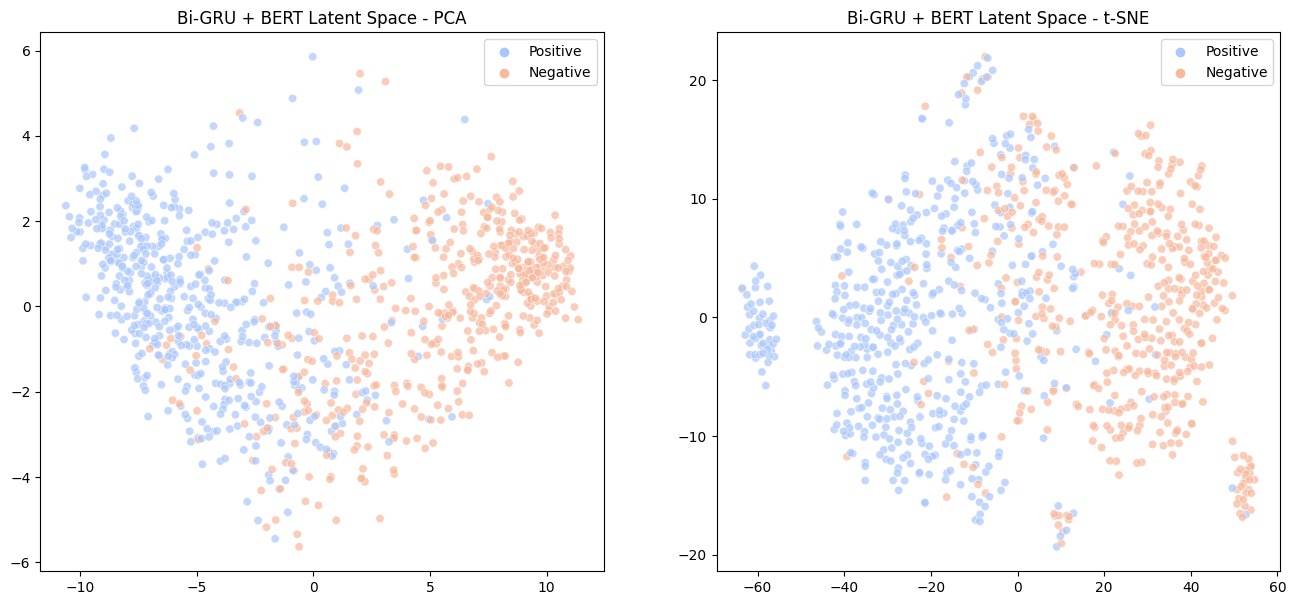

In [17]:
# --- STEP 15: Visualization (PCA & t-SNE) ---
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

def visualize_representations(model, dataloader, title="Model Representations"):
    model.eval()
    vectors = []
    labels = []
    
    print(f"Extracting vectors for {title}...")
    
    MAX_SAMPLES = 1000
    count = 0
    
    with torch.no_grad():
        for batch in dataloader:
            if "Contextual" in str(type(model)): # BERT Modeli
                input_ids = batch['bert_input_ids']
                mask = batch['bert_attention_mask']
                
                # BERT Forward pass
                bert_output = model.bert(input_ids, attention_mask=mask)
                embeddings = bert_output.last_hidden_state
                rnn_output, hidden = model.rnn(embeddings)
                
                if isinstance(hidden, tuple): hidden = hidden[0]
                features = torch.cat((hidden[-2], hidden[-1]), dim=1)
                
            else: # GloVe Model
                glove_ids = batch['glove_ids']
                embedded = model.embedding(glove_ids)
                rnn_output, hidden = model.rnn(embedded)
                
                if isinstance(hidden, tuple): hidden = hidden[0]
                features = torch.cat((hidden[-2], hidden[-1]), dim=1)

            vectors.append(features.cpu())
            labels.append(batch['labels'].cpu())
            
            count += len(batch['labels'])
            if count >= MAX_SAMPLES:
                break
    

    X = torch.cat(vectors, dim=0).numpy()[:MAX_SAMPLES]
    y = torch.cat(labels, dim=0).numpy()[:MAX_SAMPLES]
    
    # 2. PCA 
    print("Running PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # 3. t-SNE
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X)
    
    # 4. Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Name labels
    label_map = {0: 'Negative', 1: 'Positive'}
    y_str = [label_map[int(val)] for val in y]
    
    # PCA Plot
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_str, palette="coolwarm", alpha=0.7, ax=axes[0])
    axes[0].set_title(f"{title} - PCA")
    
    # t-SNE Plot
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_str, palette="coolwarm", alpha=0.7, ax=axes[1])
    axes[1].set_title(f"{title} - t-SNE")
    
    plt.show()

# Shuffle
print("Creating shuffled dataloader for visualization...")
viz_dataloader = DataLoader(test_data_list, batch_size=64, shuffle=True, collate_fn=collate_batch)

try:
    visualize_representations(model_bert_gru, viz_dataloader, title="Bi-GRU + BERT Latent Space")
except NameError:
    print("model_bert_gru not found. Trying LSTM...")
    try:
        visualize_representations(model_lstm, viz_dataloader, title="Bi-LSTM + GloVe Latent Space")
    except NameError:
        print("Error")

 Generating Compact 2x2 Master Comparison Plot...
   Processing Static (GloVe) + Bi-LSTM...
   Processing Static (GloVe) + Bi-GRU...
   Processing Contextual (BERT) + Bi-LSTM...
   Processing Contextual (BERT) + Bi-GRU...


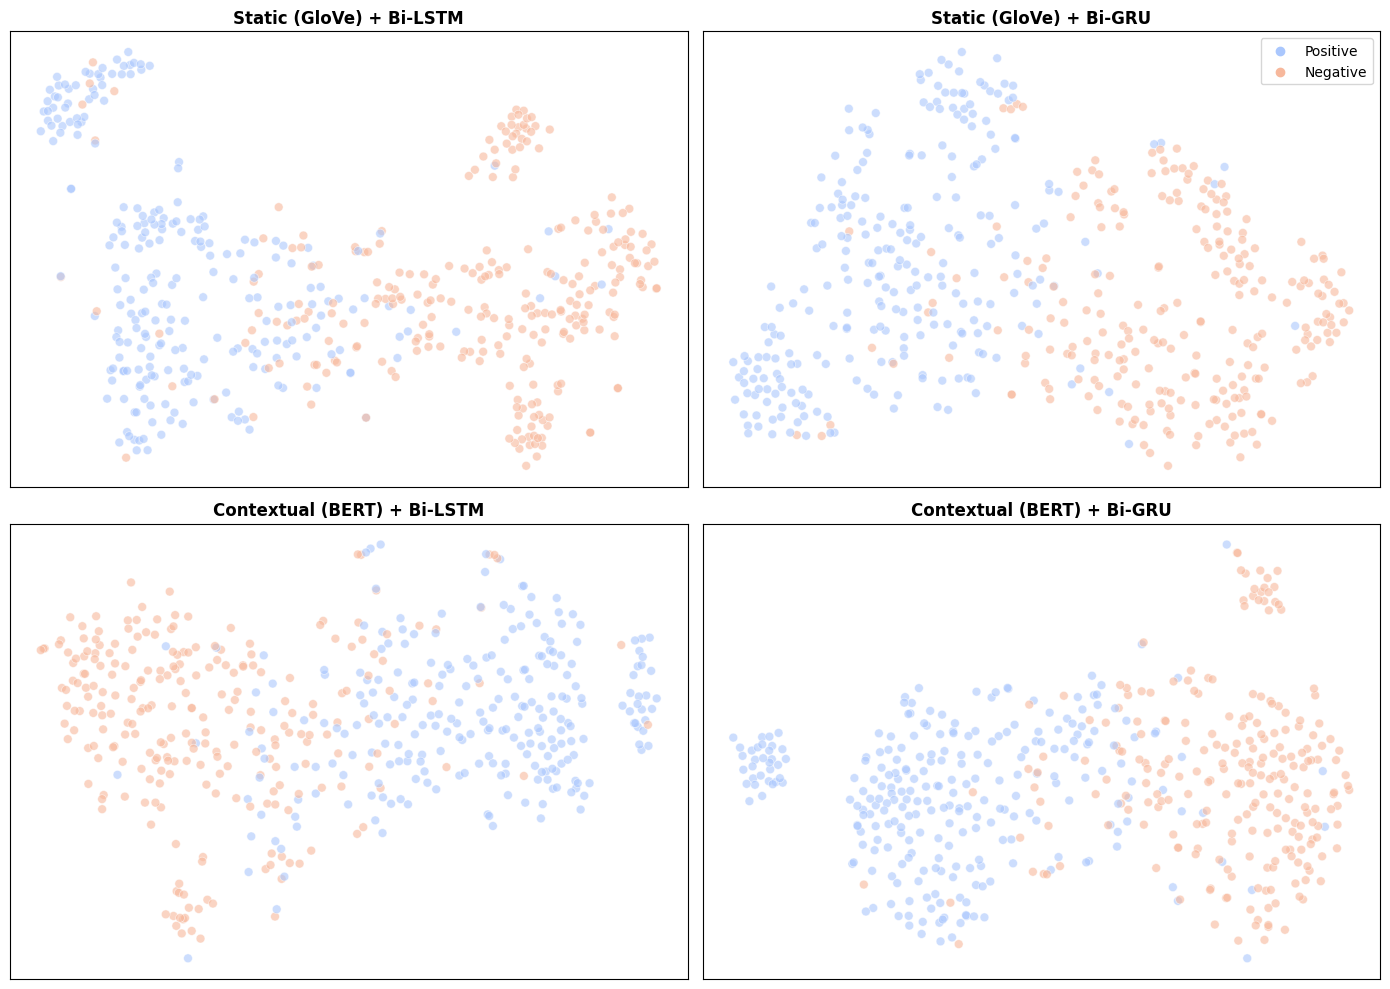

✅ Compact Master Comparison Complete.


In [18]:
# --- STEP 16 : Master Comparison (Compact 2x2 Grid) ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import numpy as np

# Helper function
def get_vectors_and_labels(model, dataloader, max_samples=500):
    model.eval()
    vectors = []
    labels = []
    count = 0
    with torch.no_grad():
        for batch in dataloader:
            if "Contextual" in str(type(model)): # BERT
                input_ids = batch['bert_input_ids']
                mask = batch['bert_attention_mask']
                bert_output = model.bert(input_ids, attention_mask=mask)
                embeddings = bert_output.last_hidden_state
                rnn_output, hidden = model.rnn(embeddings)
                if isinstance(hidden, tuple): hidden = hidden[0]
                features = torch.cat((hidden[-2], hidden[-1]), dim=1)
            else: # GloVe
                glove_ids = batch['glove_ids']
                embedded = model.embedding(glove_ids)
                rnn_output, hidden = model.rnn(embedded)
                if isinstance(hidden, tuple): hidden = hidden[0]
                features = torch.cat((hidden[-2], hidden[-1]), dim=1)

            vectors.append(features.cpu())
            labels.append(batch['labels'].cpu())
            count += len(batch['labels'])
            if count >= max_samples: break
    return torch.cat(vectors).numpy()[:max_samples], torch.cat(labels).numpy()[:max_samples]

# Define models list
models_grid = [
    (model_lstm, "Static (GloVe) + Bi-LSTM"),
    (model_gru, "Static (GloVe) + Bi-GRU"),
    (model_bert_lstm, "Contextual (BERT) + Bi-LSTM"),
    (model_bert_gru, "Contextual (BERT) + Bi-GRU")
]


fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # Reduced from (20, 16)
axes = axes.flatten()

print(" Generating Compact 2x2 Master Comparison Plot...")

for i, (model, title) in enumerate(models_grid):
    print(f"   Processing {title}...")
    try:
        X, y = get_vectors_and_labels(model, viz_dataloader)
        
        # Using standard t-SNE settings
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        X_tsne = tsne.fit_transform(X)
        
        label_map = {0: 'Negative', 1: 'Positive'}
        y_str = [label_map[val] for val in y]
        
        sns.scatterplot(
            x=X_tsne[:,0], y=X_tsne[:,1], 
            hue=y_str, 
            palette="coolwarm", 
            alpha=0.6,
            s=40, # Slightly smaller dots
            ax=axes[i],
            legend=(i==1)
        )
        axes[i].set_title(title, fontsize=12, fontweight='bold')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        
    except NameError:
        axes[i].text(0.5, 0.5, "Model Not Found", ha='center', va='center')
        axes[i].set_title(title)

plt.tight_layout()
plt.show()
print("✅ Compact Master Comparison Complete.")